# ECSE 415 - Assignment 4
## Caelan Marks - 260744278

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import itertools

## 1. Dataset Overview

In [2]:
# Define unpickle function from dataset webpage
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
# Load data
batch = unpickle('data_batch_1')
data = batch[b'data']
labels = batch[b'labels']

In [4]:
# Load test data
test = unpickle('test_batch')
test_data = test[b'data']
test_labels = test[b'labels']

In [5]:
# Reformat images because they are in raw format not rgb
data_rgb = data.copy()
for i in range(len(data_rgb)):
    image = data_rgb[i]
    im_r = image[0:1024].reshape(32, 32)
    im_g = image[1024:2048].reshape(32, 32)
    im_b = image[2048:].reshape(32, 32)

    data_rgb[i] = np.dstack((im_r, im_g, im_b)).reshape(3072)

In [6]:
test_data_rgb = test_data.copy()
for i in range(len(test_data_rgb)):
    image = test_data_rgb[i]
    im_r = image[0:1024].reshape(32, 32)
    im_g = image[1024:2048].reshape(32, 32)
    im_b = image[2048:].reshape(32, 32)

    test_data_rgb[i] = np.dstack((im_r, im_g, im_b)).reshape(3072)

In [7]:
# Load labels
label_names = unpickle('batches.meta')
label_names = label_names[b'label_names']

In [8]:
print(data.shape)
print(len(labels))

(10000, 3072)
10000


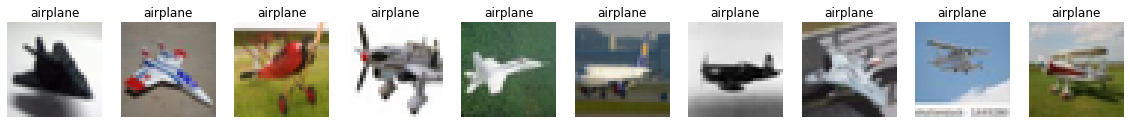

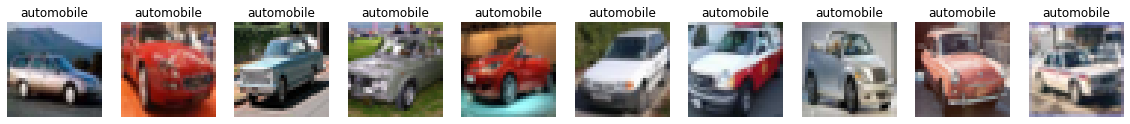

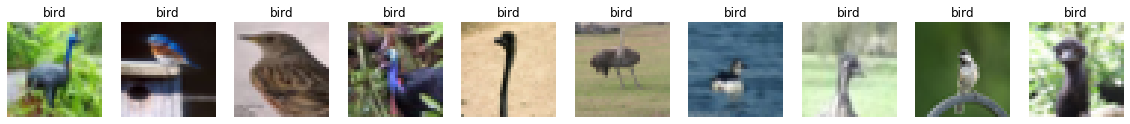

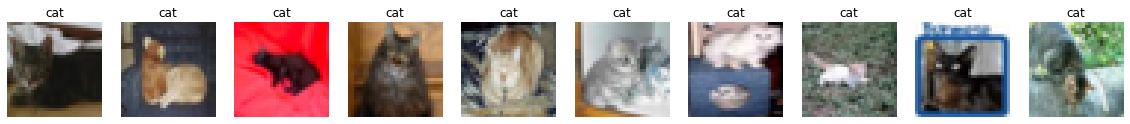

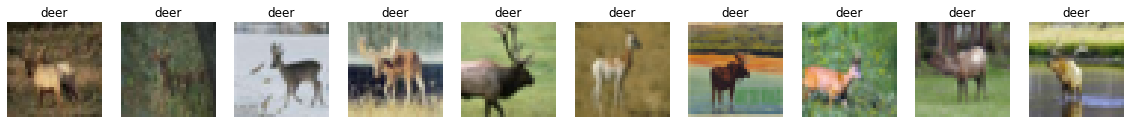

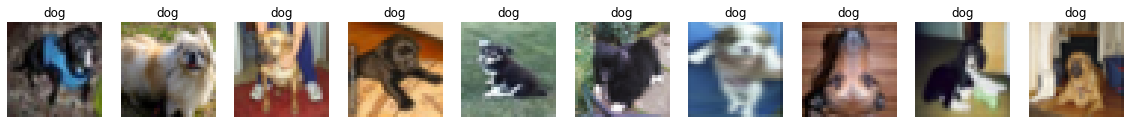

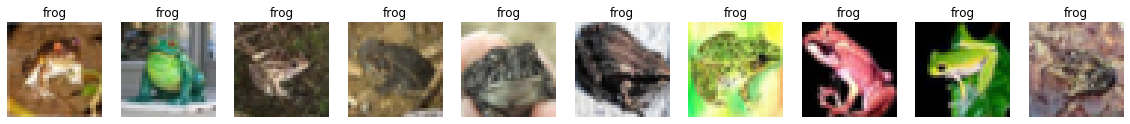

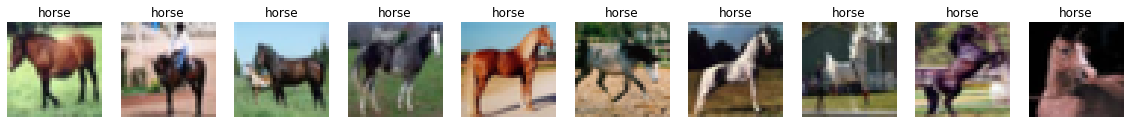

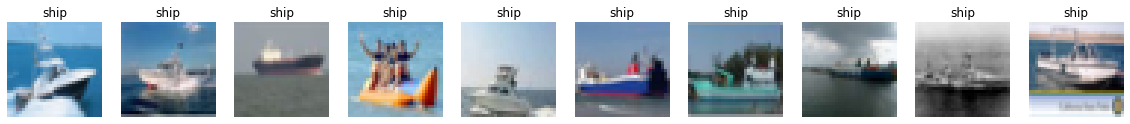

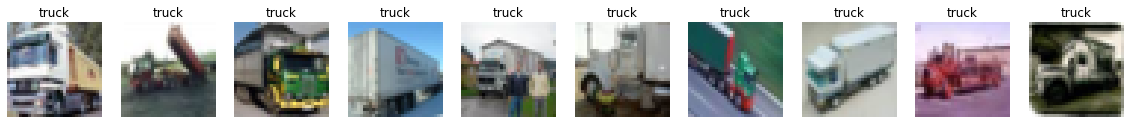

In [9]:
# Select Random batch of at least 10 images
# Display batch of images and their associated labels

for j in range(10):
    plt.figure(figsize=(20, 20))   
    index = 0
    i = 0
    while i < 10:
        if labels[index] == j:
            plt.subplot(1,10,i+1)
            plt.imshow(data_rgb[index].reshape(32, 32, 3)); plt.axis('off')
            plt.title(str(label_names[labels[index]].decode('utf-8')))
            i += 1
        index += 1
    plt.show()

### Feature Extraction

In [10]:
# Mean intensity values for the 3 different colour channels (R, G, B)
mean_intensity_features = []
for i in range(len(data)):
    image = data[i]
    r_mean = np.mean(image[0:1024])
    g_mean = np.mean(image[1024:2048])
    b_mean = np.mean(image[2048:])
    mean_intensity_features.append([r_mean, g_mean, b_mean])

In [15]:
# HoG using cell size of 8x8 and block size of 2x2 and 9 orientation bins 
# Make a function that takes in a list of images and returns a list of HoG features
def compute_hog_list(img_list, cell_size=(8, 8), block_size=(2, 2), nbins=9):
    # Set the cell_size, block size and number of orientation bins
    hog_feats_list = []
    
    for img in img_list:
        # initialize HoG descriptor
        hog = cv2.HOGDescriptor(_winSize=(32 // cell_size[1] * cell_size[1],
                                      32 // cell_size[0] * cell_size[0]),
                            _blockSize=(block_size[1] * cell_size[1],
                                        block_size[0] * cell_size[0]),
                            _blockStride=(cell_size[1], cell_size[0]),
                            _cellSize=(cell_size[1], cell_size[0]),
                            _nbins=nbins)

        img = cv2.cvtColor(img.reshape(32, 32, 3), cv2.COLOR_RGB2GRAY)

        features = hog.compute(img)
        hog_feats_list.append(features.reshape(features.shape[0]*features.shape[1]))
        
    # return list of the feature maps for all the input images
    return hog_feats_list

In [16]:
hog_features_list = compute_hog_list(data_rgb)

### Classifiers

In [17]:
# SVM
from sklearn import svm
# Random Forest
from sklearn.ensemble import RandomForestClassifier

### Evaluation Metrics

In [18]:
# Accuracy
from sklearn.metrics import accuracy_score
# Confusion Matrix
from sklearn.metrics import confusion_matrix

## 2. SVMs

### 2.1 Linear SVMs - Exploring Features

In [19]:
# Train 2 SVMs, one on each feature ectracted
# Use gamma='scale', other hyperparameters as 'default'

In [20]:
# Define and fit classifier
clf_intensity = svm.SVC(gamma='scale', kernel='linear')
clf_intensity.fit(mean_intensity_features, labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [21]:
# Format test data to be the expected rgb mean intensities
test_mean_intensity_features = []
for i in range(len(test_data)):
    image = test_data[i]
    r_mean = np.mean(image[0:1024])
    g_mean = np.mean(image[1024:2048])
    b_mean = np.mean(image[2048:])
    test_mean_intensity_features.append([r_mean, g_mean, b_mean])

In [22]:
pred_intensity = clf_intensity.predict(test_mean_intensity_features)

In [23]:
print('Intensity feature accuracy: ' + str(accuracy_score(pred_intensity, test_labels)))

Intensity feature accuracy: 0.2405


Index: 0 Label: airplane
Index: 1 Label: automobile
Index: 2 Label: bird
Index: 3 Label: cat
Index: 4 Label: deer
Index: 5 Label: dog
Index: 6 Label: frog
Index: 7 Label: horse
Index: 8 Label: ship
Index: 9 Label: truck


<Figure size 432x288 with 0 Axes>

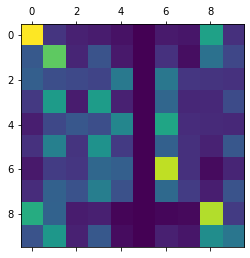

In [125]:
conf_inten = confusion_matrix(test_labels, pred_intensity)

plt.figure()
plt.matshow(conf_inten)

for i in range(len(label_names)):
    print('Index: ' + str(i) + ' Label: ' + str(label_names[i].decode('utf-8')))

In [24]:
clf_hog = svm.SVC(gamma='scale', kernel='linear')
clf_hog.fit(hog_features_list, labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [25]:
# Find hog features of the test data
hog_features_list_test = compute_hog_list(test_data_rgb)

In [26]:
pred_hog = clf_hog.predict(hog_features_list_test)

In [27]:
print('HoG feature accuracy: ' + str(accuracy_score(pred_hog, test_labels)))

HoG feature accuracy: 0.5169


Index: 0 Label: airplane
Index: 1 Label: automobile
Index: 2 Label: bird
Index: 3 Label: cat
Index: 4 Label: deer
Index: 5 Label: dog
Index: 6 Label: frog
Index: 7 Label: horse
Index: 8 Label: ship
Index: 9 Label: truck


<Figure size 432x288 with 0 Axes>

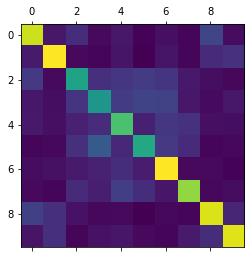

In [126]:
conf_hog = confusion_matrix(test_labels, pred_hog)

plt.figure()
plt.matshow(conf_hog)

for i in range(len(label_names)):
    print('Index: ' + str(i) + ' Label: ' + str(label_names[i].decode('utf-8')))

The HoG features perform much better than the mean intensity features. This is expected because the HoG feature list is much higher dimensional than the mean intensity features. As a result, more info is captured from the original image but the classfier is more complicated to learn. A scenario where they would likely perform similarly is one where you are trying to classify objects by their colour.

### 2.2 Non-linear SVMs - Exploring SVM Kernels

In [28]:
# Use HoG features, train two different SVMs with different kernels, polynomial and radial basis function
# Use gamma='scale', keep other hyperparamters as default

In [29]:
clf_poly = svm.SVC(gamma='scale', kernel='poly')
clf_rbf = svm.SVC(gamma='scale', kernel='rbf')

In [30]:
clf_poly.fit(hog_features_list, labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [31]:
pred_poly = clf_poly.predict(hog_features_list_test)

In [169]:
print('SVM with Polynomial Kernel: ' + str(accuracy_score(pred_poly, test_labels)))

SVM with Polynomial Kernel: 0.5642


Index: 0 Label: airplane
Index: 1 Label: automobile
Index: 2 Label: bird
Index: 3 Label: cat
Index: 4 Label: deer
Index: 5 Label: dog
Index: 6 Label: frog
Index: 7 Label: horse
Index: 8 Label: ship
Index: 9 Label: truck


<Figure size 432x288 with 0 Axes>

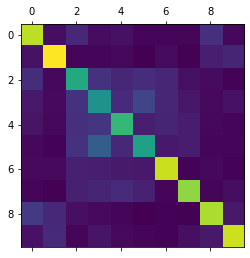

In [123]:
conf_poly = confusion_matrix(test_labels, pred_poly)

plt.figure()
plt.matshow(conf_poly)

for i in range(len(label_names)):
    print('Index: ' + str(i) + ' Label: ' + str(label_names[i].decode('utf-8')))

In [33]:
clf_rbf.fit(hog_features_list, labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [34]:
pred_rbf = clf_rbf.predict(hog_features_list_test)

In [168]:
print('SVM with RBF Kernel Accuracy: ' + str(accuracy_score(pred_rbf, test_labels)))

SVM with RBF Kernel Accuracy: 0.5928


Index: 0 Label: airplane
Index: 1 Label: automobile
Index: 2 Label: bird
Index: 3 Label: cat
Index: 4 Label: deer
Index: 5 Label: dog
Index: 6 Label: frog
Index: 7 Label: horse
Index: 8 Label: ship
Index: 9 Label: truck


<Figure size 432x288 with 0 Axes>

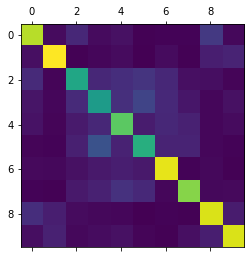

In [124]:
conf_rbf = confusion_matrix(test_labels, pred_rbf)

plt.figure()
plt.matshow(conf_rbf)

for i in range(len(label_names)):
    print('Index: ' + str(i) + ' Label: ' + str(label_names[i].decode('utf-8')))

The radial basis function kernel results in the best accuracy compared to the polynomial kernel. This is expected because the RBF can learn some more complex non-linear boundaries that may not may not be ideally fit by a polynomial kernel.

## 3. Random Forest Classifiers

### 3.1 RF - Exploring Performance of HoG features

In [36]:
# Use HoG features
# Train random forest using n_estimators=100, criterion='entropy', rest are default.
clf_rf = RandomForestClassifier(n_estimators=100, criterion='entropy')
# Report the performance of the classifier

In [37]:
clf_rf.fit(hog_features_list, labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [38]:
pred_rf = clf_rf.predict(hog_features_list_test)

In [167]:
print('RF with HoG Accuracy: ' + str(accuracy_score(pred_rf, test_labels)))

RF with HoG Accuracy: 0.5046


Index: 0 Label: airplane
Index: 1 Label: automobile
Index: 2 Label: bird
Index: 3 Label: cat
Index: 4 Label: deer
Index: 5 Label: dog
Index: 6 Label: frog
Index: 7 Label: horse
Index: 8 Label: ship
Index: 9 Label: truck


<Figure size 432x288 with 0 Axes>

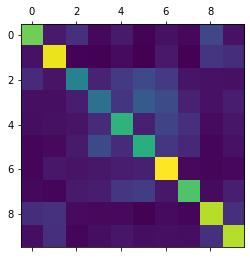

In [127]:
conf_rf = confusion_matrix(test_labels, pred_rf)

plt.figure()
plt.matshow(conf_rf)

for i in range(len(label_names)):
    print('Index: ' + str(i) + ' Label: ' + str(label_names[i].decode('utf-8')))

The RF classifier with 100 trees obtains an accuracy of 49.95%.

### 3.2 RF - Exploring Different Number of Trees (estimators)

In [128]:
# Try with n_estimators = 40, 200, 250, write observations
clf_rf_40 = RandomForestClassifier(n_estimators=40, criterion='entropy')
clf_rf_200 = RandomForestClassifier(n_estimators=200, criterion='entropy')
clf_rf_250 = RandomForestClassifier(n_estimators=250, criterion='entropy')

In [129]:
clf_rf_40.fit(hog_features_list, labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [130]:
pred_rf_40 = clf_rf_40.predict(hog_features_list_test)

In [164]:
print('RF with 40 trees Accuracy: ' + str(accuracy_score(pred_rf_40, test_labels)))

RF with 40 trees Accuracy: 0.4495


In [132]:
clf_rf_200.fit(hog_features_list, labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [133]:
pred_rf_200 = clf_rf_200.predict(hog_features_list_test)

In [165]:
print('RF with 200 trees Accuracy: ' + str(accuracy_score(pred_rf_200, test_labels)))

RF with 200 trees Accuracy: 0.5153


In [135]:
clf_rf_250.fit(hog_features_list, labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [139]:
pred_rf_250 = clf_rf_250.predict(hog_features_list_test)

In [166]:
print('RF with 250 trees Accuracy: ' + str(accuracy_score(pred_rf_250, test_labels)))

RF with 250 trees Accuracy: 0.5199


As the number of trees increases, the accuracy of the RF classifier seems to increase. This is expected as having more trees should on average always increase the accuracy of the model, unless it has reached a plateau. The RF classifier with the best performance is composed of 250 trees. The difference between 200 and 250 is minimal and usually they alternate which is better depending on the randomness of the run. This shows that it has reached the plateau in accuracy by 200 trees.

## 4. Comparison of Classifiers

### 4.1 Performance Analysis

In [144]:
pred_rbf_train = clf_rbf.predict(hog_features_list)

In [148]:
print('RBF Training Accuracy: ' + str(accuracy_score(pred_rbf_train, labels)))

RBF Training Accuracy: 0.8206


Index: 0 Label: airplane
Index: 1 Label: automobile
Index: 2 Label: bird
Index: 3 Label: cat
Index: 4 Label: deer
Index: 5 Label: dog
Index: 6 Label: frog
Index: 7 Label: horse
Index: 8 Label: ship
Index: 9 Label: truck


<Figure size 432x288 with 0 Axes>

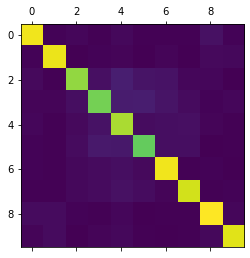

In [147]:
conf_rbf_train = confusion_matrix(labels, pred_rbf_train)

plt.figure()
plt.matshow(conf_rbf_train)

for i in range(len(label_names)):
    print('Index: ' + str(i) + ' Label: ' + str(label_names[i].decode('utf-8')))

In [163]:
print('RBF Test Accuracy: ' + str(accuracy_score(pred_rbf, test_labels)))

RBF Test Accuracy: 0.5928


Index: 0 Label: airplane
Index: 1 Label: automobile
Index: 2 Label: bird
Index: 3 Label: cat
Index: 4 Label: deer
Index: 5 Label: dog
Index: 6 Label: frog
Index: 7 Label: horse
Index: 8 Label: ship
Index: 9 Label: truck


<Figure size 432x288 with 0 Axes>

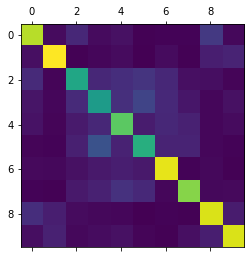

In [50]:
conf1 = confusion_matrix(test_labels, pred_rbf)

plt.figure()
plt.matshow(conf1)

for i in range(len(label_names)):
    print('Index: ' + str(i) + ' Label: ' + str(label_names[i].decode('utf-8')))

The SVM classifier seems to struggle with classifying the bird, cat, deer and dog categories. 

In [140]:
pred_rf_250_train = clf_rf_250.predict(hog_features_list)

In [161]:
print('RF Train Accuracy: ' + str(accuracy_score(pred_rf_250_train, labels)))

RF Train Accuracy: 1.0


Index: 0 Label: airplane
Index: 1 Label: automobile
Index: 2 Label: bird
Index: 3 Label: cat
Index: 4 Label: deer
Index: 5 Label: dog
Index: 6 Label: frog
Index: 7 Label: horse
Index: 8 Label: ship
Index: 9 Label: truck


<Figure size 432x288 with 0 Axes>

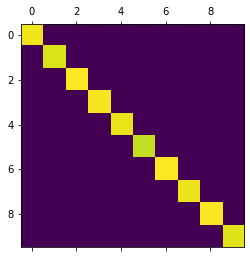

In [142]:
conf_rf_250_train = confusion_matrix(labels, pred_rf_250_train)

plt.figure()
plt.matshow(conf_rf_250_train)

for i in range(len(label_names)):
    print('Index: ' + str(i) + ' Label: ' + str(label_names[i].decode('utf-8')))

In [162]:
print('RF Test Accuracy: ' + str(accuracy_score(pred_rf_250, test_labels)))

RF Test Accuracy: 0.5199


Index: 0 Label: airplane
Index: 1 Label: automobile
Index: 2 Label: bird
Index: 3 Label: cat
Index: 4 Label: deer
Index: 5 Label: dog
Index: 6 Label: frog
Index: 7 Label: horse
Index: 8 Label: ship
Index: 9 Label: truck


<Figure size 432x288 with 0 Axes>

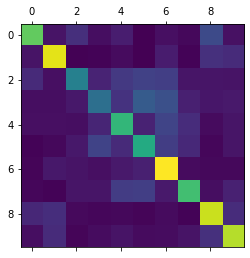

In [51]:
conf2 = confusion_matrix(test_labels, pred_rf_250)

plt.figure()
plt.matshow(conf2)

for i in range(len(label_names)):
    print('Index: ' + str(i) + ' Label: ' + str(label_names[i].decode('utf-8')))

The RF classifier seems to struggle with the bird, cat, deer and dor categories. These are the same categories as the SVM although it seems to struggle even more than the SVM. What is interesting is that the SVM has a better test score while the RF has a better training accuracy. This shows that the RF classifier overfits to the training data and doesn't generalize as well as the SVM classifier.

### 4.2 Exploring Different Parameters of HoG

In [52]:
# Try changing the block size, cell size, and orientation bins on either best SVM or best RF.
hog_features_list_cell = compute_hog_list(data_rgb, cell_size=(16, 16))
hog_features_list_cell_test = compute_hog_list(test_data_rgb, cell_size=(16, 16))

hog_features_list_block = compute_hog_list(data_rgb, block_size=(4, 4))
hog_features_list_block_test = compute_hog_list(test_data_rgb, block_size=(4, 4))

hog_features_list_nbins = compute_hog_list(data_rgb, nbins=18)
hog_features_list_nbins_test = compute_hog_list(test_data_rgb, nbins=18)

In [53]:
clf_cell = svm.SVC(gamma='scale', kernel='rbf')

In [54]:
# New cell size
clf_cell.fit(hog_features_list_cell, labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [55]:
pred_cell = clf_cell.predict(hog_features_list_cell_test)

In [150]:
print('HoG Accuracy with 16x16 cell size: ' + str(accuracy_score(pred_cell, test_labels)))

HoG Accuracy with 16x16 cell size: 0.475


In [57]:
clf_block = svm.SVC(gamma='scale', kernel='rbf')

In [58]:
# New block size
clf_block.fit(hog_features_list_block, labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [59]:
pred_block = clf_block.predict(hog_features_list_block_test)

In [151]:
print('HoG Accuracy with 4x4 block size: ' + str(accuracy_score(pred_block, test_labels)))

HoG Accuracy with 4x4 block size: 0.5623


In [61]:
clf_nbins = svm.SVC(gamma='scale', kernel='rbf')

In [62]:
# new number of orientation bins
clf_nbins.fit(hog_features_list_nbins, labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [63]:
pred_nbins = clf_nbins.predict(hog_features_list_nbins_test)

In [152]:
print('HoG Accuracy with 18 orientation bins: ' + str(accuracy_score(pred_nbins, test_labels)))

HoG Accuracy with 18 orientation bins: 0.5878


Given the three experiments that I have performed, it seems that increasing nbins, block size and cell size, all seem to decrease the overall accuracy of the SVM classifier.

### 4.3 Folded Validation

In [65]:
# Take the best performing HoG features, SVM and RF and perform 3-fold validation using any 3 data batches.
batch2 = unpickle('data_batch_2')
data2 = batch2[b'data']
labels2 = batch2[b'labels']
batch3 = unpickle('data_batch_3')
data3 = batch3[b'data']
labels3 = batch3[b'labels']

# Report the accuracies using 3-fold validation

In [66]:
# Format batch 2
data2_rgb = data2.copy()
for i in range(len(data2_rgb)):
    image = data2_rgb[i]
    im_r = image[0:1024].reshape(32, 32)
    im_g = image[1024:2048].reshape(32, 32)
    im_b = image[2048:].reshape(32, 32)

    data2_rgb[i] = np.dstack((im_r, im_g, im_b)).reshape(3072)

In [67]:
# Format batch 3
data3_rgb = data3.copy()
for i in range(len(data3_rgb)):
    image = data3_rgb[i]
    im_r = image[0:1024].reshape(32, 32)
    im_g = image[1024:2048].reshape(32, 32)
    im_b = image[2048:].reshape(32, 32)

    data3_rgb[i] = np.dstack((im_r, im_g, im_b)).reshape(3072)

In [69]:
# Compute HoG feature lists
hog_features_list_batch2 = compute_hog_list(data2_rgb)
hog_features_list_batch3 = compute_hog_list(data3_rgb)

In [70]:
clf_best_svm3 = svm.SVC(gamma='scale', kernel='rbf')

In [71]:
# Fold 1 (batch 3)

In [72]:
clf_best_svm3.fit(hog_features_list_batch3, labels3)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [73]:
pred_svm_batch3 = clf_best_svm3.predict(hog_features_list_test)

In [154]:
svm_batch3_acc = accuracy_score(pred_svm_batch3, test_labels)
print('SVM Accuracy when trained on batch 3 :' + str(svm_batch3_acc))

SVM Accuracy when trained on batch 3 :0.5931


In [75]:
clf_best_rf3 = RandomForestClassifier(n_estimators=250, criterion='entropy')

In [76]:
clf_best_rf3.fit(hog_features_list_batch3, labels3)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [77]:
pred_rf_batch3 = clf_best_rf3.predict(hog_features_list_test)

In [156]:
rf_batch3_acc = accuracy_score(pred_rf_batch3, test_labels)
print('RF Accuracy when trained on batch 3: ' + str(rf_batch3_acc))

RF Accuracy when trained on batch 3: 0.5226


In [79]:
# Fold 2 (batch 2)

In [80]:
clf_best_svm2 = svm.SVC(gamma='scale', kernel='rbf')

In [81]:
clf_best_svm2.fit(hog_features_list_batch2, labels2)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [82]:
pred_svm_batch2 = clf_best_svm2.predict(hog_features_list_test)

In [157]:
svm_batch2_acc = accuracy_score(pred_svm_batch2, test_labels)
print('SVM Accuracy when trained on batch 2: ' + str(svm_batch2_acc))

SVM Accuracy when trained on batch 2: 0.592


In [84]:
clf_best_rf2 = RandomForestClassifier(n_estimators=250, criterion='entropy')

In [85]:
clf_best_rf2.fit(hog_features_list_batch2, labels2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [86]:
pred_rf_batch2 = clf_best_rf2.predict(hog_features_list_test)

In [158]:
rf_batch2_acc = accuracy_score(pred_rf_batch2, test_labels)
print('RF Accuracy when trained on batch 2: ' + str(rf_batch2_acc))

RF Accuracy when trained on batch 2: 0.523


In [88]:
# Fold 3 (batch 1)

In [89]:
clf_best_svm1 = svm.SVC(gamma='scale', kernel='rbf')

In [90]:
clf_best_svm1.fit(hog_features_list, labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [91]:
pred_svm_batch1 = clf_best_svm1.predict(hog_features_list_test)

In [159]:
svm_batch1_acc = accuracy_score(pred_svm_batch1, test_labels)
print('SVM Accuracy when trained on batch 1: ' + str(svm_batch1_acc))

SVM Accuracy when trained on batch 1: 0.5928


In [93]:
clf_best_rf1 = RandomForestClassifier(n_estimators=250, criterion='entropy')

In [94]:
clf_best_rf1.fit(hog_features_list, labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [95]:
pred_rf_batch1 = clf_best_rf1.predict(hog_features_list_test)

In [160]:
rf_batch1_acc = accuracy_score(pred_rf_batch1, test_labels)
print('RF Accuracy when trained on batch 1: ' + str(rf_batch1_acc))

RF Accuracy when trained on batch 1: 0.5222


In [97]:
# Fold 1 trains on batch 3
# Fold 2 trains on batch 2
# Fold 3 trains on batch 1

print('Fold 1 SVM accuracy: ' + str(svm_batch3_acc))
print('Fold 1 RF accuracy: ' + str(rf_batch3_acc))
print('Fold 2 SVM accuracy: ' + str(svm_batch2_acc))
print('Fold 2 RF accuracy: ' + str(rf_batch2_acc))
print('Fold 3 SVM accuracy: ' + str(svm_batch1_acc))
print('Fold 3 RF accuracy: ' + str(rf_batch1_acc))
print('Mean SVM accuracy: ' + str(np.mean([svm_batch1_acc, svm_batch2_acc, svm_batch3_acc])))
print('Mean RF accuracy: ' + str(np.mean([rf_batch1_acc, rf_batch2_acc, rf_batch3_acc])))

Fold 1 SVM accuracy: 0.5931
Fold 1 RF accuracy: 0.5226
Fold 2 SVM accuracy: 0.592
Fold 2 RF accuracy: 0.523
Fold 3 SVM accuracy: 0.5928
Fold 3 RF accuracy: 0.5222
Mean SVM accuracy: 0.5926333333333333
Mean RF accuracy: 0.5226


All folds seem to obtain similar accuracies, this makes sense given that they are all randomly distributed and should have on average a similar number of examples easy and hard to classify examples. 

### 4.4 Ensemble Classifiers

In [98]:
# Build an ensemble method using the 6 RF and SVM classifiers (3 each) from the previous section. 
# Compare the accuracies and the confusion matrix of the ensemble with that of the best performing individual classifier.

# Which one do you expect to perform better? Why?

In [112]:
# Merge predicitions
predictions = np.concatenate([np.asarray(pred_svm_batch1).reshape(10000, 1), np.asarray(pred_svm_batch2).reshape(10000, 1), np.asarray(pred_svm_batch3).reshape(10000, 1), 
                              np.asarray(pred_rf_batch1).reshape(10000, 1), np.asarray(pred_rf_batch2).reshape(10000, 1), np.asarray(pred_rf_batch3).reshape(10000, 1)], axis=1)

In [115]:
# Count prediction votes
vote_counts = []
for prediction in predictions:
    vote_counts.append(np.bincount(prediction))

In [116]:
# Determine majority vote
majority_vote = []
for vote_count in vote_counts:
    majority_vote.append(np.argmax(vote_count))

In [118]:
print(accuracy_score(majority_vote, test_labels))

0.5868


Index: 0 Label: airplane
Index: 1 Label: automobile
Index: 2 Label: bird
Index: 3 Label: cat
Index: 4 Label: deer
Index: 5 Label: dog
Index: 6 Label: frog
Index: 7 Label: horse
Index: 8 Label: ship
Index: 9 Label: truck


<Figure size 432x288 with 0 Axes>

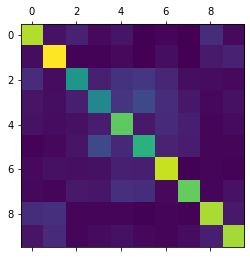

In [120]:
conf_eclf = confusion_matrix(test_labels, majority_vote)

plt.figure()
plt.matshow(conf_eclf)
for i in range(len(label_names)):
    print('Index: ' + str(i) + ' Label: ' + str(label_names[i].decode('utf-8')))

Index: 0 Label: airplane
Index: 1 Label: automobile
Index: 2 Label: bird
Index: 3 Label: cat
Index: 4 Label: deer
Index: 5 Label: dog
Index: 6 Label: frog
Index: 7 Label: horse
Index: 8 Label: ship
Index: 9 Label: truck


<Figure size 432x288 with 0 Axes>

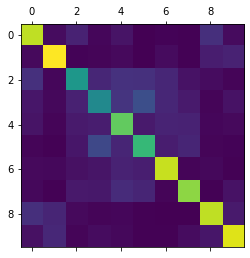

In [122]:
conf_best = confusion_matrix(test_labels, pred_svm_batch3)

plt.figure()
plt.matshow(conf_best)
for i in range(len(label_names)):
    print('Index: ' + str(i) + ' Label: ' + str(label_names[i].decode('utf-8')))

As can be seen when comparing the accuracies of the best classifier to the ensemble method, the best classifier has the better accuracy. This is further seen in the confusion matrices where they perform similarly in most cases although the best SVM performs slightly better in some categories. This is expected because the benefit of the ensemble method comes when you combine complementary classifiers. In this case many of the classifiers are not complementary and then when combined cause the overall accuracy to decrease. We know this from section 4.1 where both the SVM and RF classifiers struggle to classify the same categories.